In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "seaborn"

In [2]:
RANDOM_STATE = 1234

In [3]:
df = pd.read_csv("breastcancer.csv", header=None)

In [4]:
def split_data(df, train_size=0.7, random_state=RANDOM_STATE):

    df_train = df.sample(frac=train_size, random_state=random_state)
    df_test = df.drop(index=df_train.index)

    x_train, y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1]
    x_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]

    return x_train, x_test, y_train, y_test

In [5]:
class Preprocesser:
    def __init__(self, x):
        self.min = np.min(x, axis=0)
        self.max = np.max(x, axis=0)

    def make_scaling(self, x):
        x_scaled = (x - self.min) / (self.max - self.min)
        return x_scaled

    def reverse_scaling(self, x_scaled):
        x_original = x_scaled * (self.max - self.min) + self.min
        return x_original

In [6]:
x_train, x_test, y_train, y_test = split_data(df)

In [7]:
x_train_scaled = Preprocesser(x_train).make_scaling(x_train)
x_test_scaled = Preprocesser(x_train).make_scaling(x_test)

In [8]:
def get_metrics(y_test, y_pred):
    tp, tn, fp, fn = 0, 0, 0, 0
    # counting tp, tn, fn, fp
    for x, y in list(zip(y_test, y_pred)):
        if x == 1 and x == y:  # y == 1
            tp += 1
        elif x == 1 and x != y:  # y == 0
            fn += 1
        elif x == 0 and x == y:  # y == 0
            tn += 1
        elif x == 0 and x != y:  # y == 1
            fp += 1
    # create dict of metrics
    metrics = dict.fromkeys(["precision", "recall", "f1_score", "accuracy"])
    metrics["precision"] = tp / (tp + fp)
    metrics["recall"] = tp / (tp + fn)
    metrics["f1_score"] = (
        2
        * (metrics["recall"] * metrics["precision"])
        / (metrics["recall"] + metrics["precision"])
    )
    metrics["accuracy"] = (tp + tn) / (tp + fp + tn + fn)

    return metrics

In [83]:
def kfold_cross_validation(X_train, y_train, classifier, k=10):

    k_info = []
    k_indices = np.array_split(X_train.index, k)

    for i in range(k):

        # create test fold, using the i-th chunk of the list of indices
        X_test_fold = X_train.loc[k_indices[i]]
        y_test_fold = y_train.loc[k_indices[i]]

        # create train fold, using the rest that it wasn't used on test
        X_train_fold = X_train.drop(index=k_indices[i])
        y_train_fold = y_train.drop(index=k_indices[i])

        # normalize train data
        X_train_fold_scaled = Preprocesser(X_train_fold).make_scaling(X_train_fold)
        X_test_fold_scaled = Preprocesser(X_train_fold).make_scaling(X_test_fold)

        # train models
        classifier.fit(X_train_fold_scaled, y_train_fold)

        # predict
        y_pred = classifier.predict(X_test_fold_scaled)

        # get_scores
        metrics = get_metrics(y_test_fold, y_pred)

        # save_results
        k_info.append(dict(indices=k_indices[i], metrics=metrics))

    return k_info

In [84]:
class LogisticRegression:
    def __init__(self, alfa=0.5, n_iter=250):
        self.alfa = alfa
        self.n_iter = n_iter

    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y):
        self.W = np.ones(shape=(1 + X.shape[1])) * 0.5
        self.cost_values = []
        N = y.size

        for i in range(self.n_iter):
            output = self.sigmoid(np.dot(X, self.W[1:]) + self.W[0])
            errors = y - output
            self.W[1:] += (self.alfa / N) * X.T.dot(errors)
            self.W[0] += (self.alfa / N) * errors.sum()

            cost = -(1 / N) * y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_values.append(cost)

    def predict(self, X):
        return np.where(np.dot(X, self.W[1:]) + self.W[0] >= 0.0, 1, 0)

In [86]:
lg = LogisticRegression()
lg.fit(x_train_scaled, y_train)
get_metrics(y_test, lg.predict(x_test_scaled))

{'precision': 0.9622641509433962,
 'recall': 0.9807692307692307,
 'f1_score': 0.9714285714285713,
 'accuracy': 0.9649122807017544}

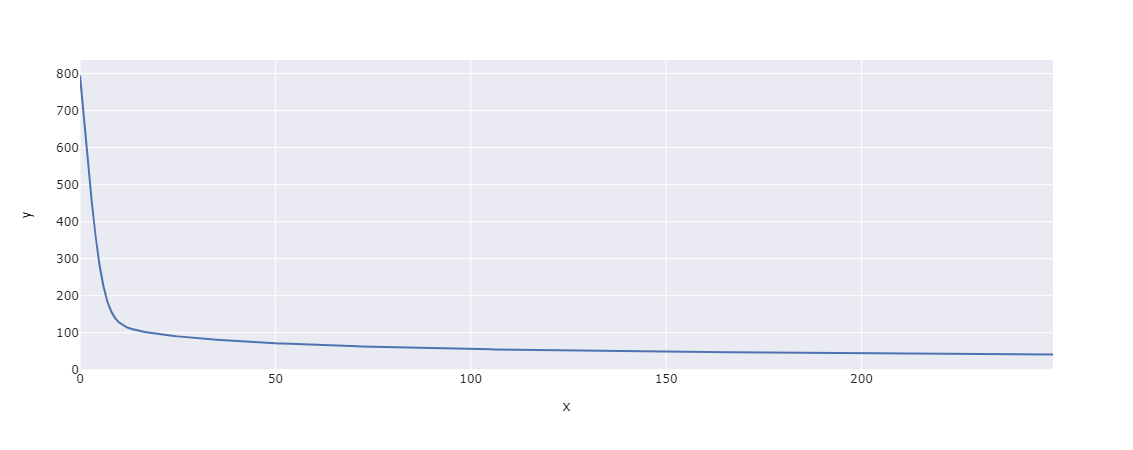

In [87]:
px.line(x=list(range(len(lg.cost_values))), y=lg.cost_values)

In [88]:
from sklearn.linear_model import LogisticRegression as LRSK
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), LRSK())
cross_val_score(clf, X=x_train, y=y_train, cv=10)

array([0.975, 0.95 , 0.975, 0.95 , 0.975, 1.   , 1.   , 1.   , 1.   ,
       1.   ])

In [96]:
metrics_lr = kfold_cross_validation(x_train, y_train, LogisticRegression(), k=10)

In [145]:
def get_mean_metrics(metrics_):
    
    precision_list = [item["metrics"]["precision"] for item in metrics_]
    accuracy_list = [item["metrics"]["accuracy"] for item in metrics_]
    recall_list = [item["metrics"]["recall"] for item in metrics_]
    f1_score_list = [item["metrics"]["f1_score"] for item in metrics_]
    
    values = dict(
        precision=[np.mean(precision_list), np.std(precision_list)],
        accuracy=[np.mean(accuracy_list), np.std(accuracy_list)],
        recall=[np.mean(recall_list), np.std(recall_list)],
        f1_score=[np.mean(f1_score_list), np.std(f1_score_list)],
    )
    
    pretty_text = (
        f"Precision: {values['precision'][0]:.2f} ± {values['precision'][1]:.2f}"
    )
    pretty_text += (
        f"\nAccuracy: {values['accuracy'][0]:.2f} ± {values['accuracy'][1]:.2f}"
    )
    pretty_text += f"\nRecall: {values['recall'][0]:.2f} ± {values['recall'][1]:.2f}"
    pretty_text += (
        f"\nF1 Score: {values['f1_score'][0]:.2f} ± {values['f1_score'][1]:.2f}"
    )
    print(pretty_text)

In [146]:
get_mean_metrics(metrics_lr)

Precision: 0.93 ± 0.06
Accuracy: 0.94 ± 0.05
Recall: 0.99 ± 0.02
F1 Score: 0.96 ± 0.03


# KNN ( K = 3, Euclideano)

# Decision Trees

In [148]:
from sklearn.tree import DecisionTreeClassifier

In [155]:
metrics_tree = kfold_cross_validation(x_train, y_train, DecisionTreeClassifier(), k=10)

In [156]:
get_mean_metrics(metrics_tree)

Precision: 0.94 ± 0.05
Accuracy: 0.92 ± 0.03
Recall: 0.94 ± 0.03
F1 Score: 0.94 ± 0.02


In [157]:
dt.fit(X=x_train_scaled, y=y_train)

DecisionTreeClassifier()

In [159]:
get_metrics(y_test, dt.predict(x_test_scaled))

{'precision': 0.94,
 'recall': 0.9038461538461539,
 'f1_score': 0.9215686274509804,
 'accuracy': 0.9064327485380117}

In [4]:
class AlgoritmosLista02:
    def __init__(self, dataset_x, dataset_y):
        self.X = dataset_X
        self.y = dataset_y

    def train_test_split(self, train_size=0.7):
        pass

    def _LR(self):
        pass

    def _KNN(self):
        pass

    def _ADG(self):
        pass

    def _NBG(self):
        pass

    def _DT(self):
        pass

    def train(self):
        pass

    def make_cross_validation(self):
        pass

    def train_model(self, how=None, cross_validation=False):
        pass

    def get_model_scores(self):
        pass